# FNNn and Glove Embeddings Model on X.com

In [16]:
#Standard Imports

import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 1. Load data
df = pd.read_csv("x_en_dataset.csv")

In [3]:
# 2. Binary sentiment labels
df = df[df['sentiment'].notna()]
df['label'] = df['sentiment'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
# 3. Clean and tokenize
def preprocess(text):
    text = re.sub(r'http\S+', '', str(text).lower())
    return re.findall(r'\b\w+\b', text)

df['tokens'] = df['cleaned_text'].apply(preprocess)


In [5]:
# 4. Build vocabulary
vocab = {}
for tokens in df['tokens']:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab) + 1  

In [7]:
# 5. Load GloVe embeddings
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

embedding_matrix = np.zeros((len(vocab)+1, embedding_dim))
for word, idx in vocab.items():
    vec = embeddings_index.get(word)
    if vec is not None:
        embedding_matrix[idx] = vec

In [ ]:
# 6. Text to sequences
def encode(tokens):
    return [vocab.get(token, 0) for token in tokens]

df['input_ids'] = df['tokens'].apply(encode)

In [9]:
# 7. Pad sequences
def pad_sequence(seq, max_len=50):
    return seq[:max_len] + [0]*(max_len - len(seq))

df['input_ids'] = df['input_ids'].apply(lambda x: pad_sequence(x, 50))

In [11]:
# 8. PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)
    

X_train, X_test, y_train, y_test = train_test_split(df['input_ids'].tolist(), df['label'].tolist(), test_size=0.2)

train_ds = SentimentDataset(X_train, y_train)
test_ds = SentimentDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)


In [12]:
# 9. Define FFNN Model
class SentimentFFNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * 50, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.embedding(x)  
        x = x.view(x.size(0), -1)  
        return self.fc(x)

model = SentimentFFNN(len(vocab)+1, embedding_dim, embedding_matrix)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# 10. Train Model
train_losses = []
train_f1s = []

for epoch in range(5):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for inputs, labels in tqdm(train_dl):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    avg_loss = total_loss / len(train_dl)
    f1 = f1_score(all_labels, all_preds, average='macro')
    train_losses.append(avg_loss)
    train_f1s.append(f1)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, F1: {f1:.4f}")

100%|██████████| 125/125 [00:00<00:00, 668.55it/s]


Epoch 1 - Loss: 0.1556, F1: 0.9404


100%|██████████| 125/125 [00:00<00:00, 706.11it/s]


Epoch 2 - Loss: 0.1133, F1: 0.9623


100%|██████████| 125/125 [00:00<00:00, 628.42it/s]


Epoch 3 - Loss: 0.0859, F1: 0.9705


100%|██████████| 125/125 [00:00<00:00, 718.85it/s]


Epoch 4 - Loss: 0.0690, F1: 0.9786


100%|██████████| 125/125 [00:00<00:00, 757.47it/s]

Epoch 5 - Loss: 0.0470, F1: 0.9878


In [18]:
# 11. Evaluate Model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_dl:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"\nFinal Test Accuracy: {acc*100:.2f}%")
print(f"Final Test F1 Score: {f1:.4f}")


Final Test Accuracy: 71.80%
Final Test F1 Score: 0.7124


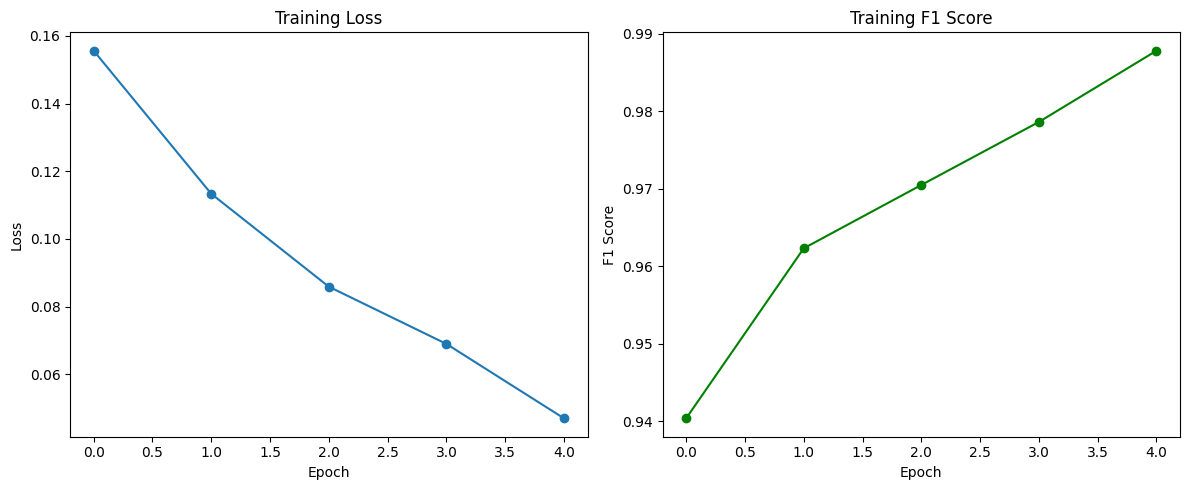

In [19]:
# 12. Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_f1s, marker='o', color='green')
plt.title("Training F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()

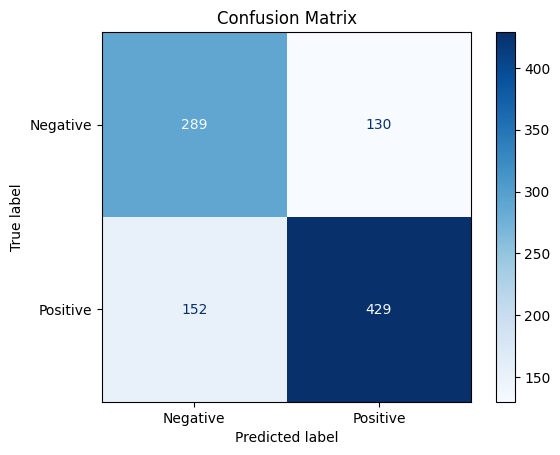

In [20]:
# Confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()